# Лабораторная работа №4 - Восстановление функции распределения вероятности

> **Исполнил:** Гимазетдинов Дмитрий, М8О-109СВ-24;

> **Тип:** Хвост 1 семестр.

# Задание
- [X] Реализовать метод восстановления плотности вероятности двумя способами:
    - [X] EM-алгоритм
    - [X] Ядерное сглаживание
-[X] Применить данные методы на любом наборе случайных точек

# Библиотечная реализация

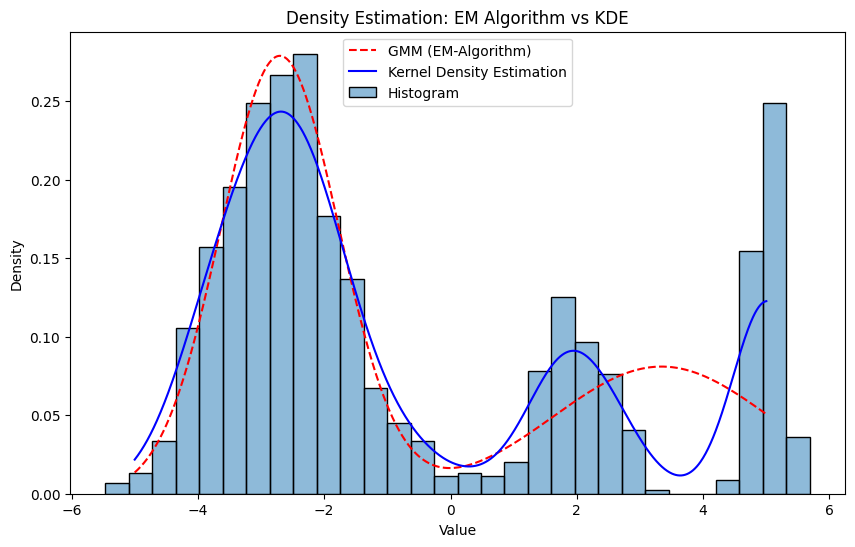

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

# Генерация случайных данных
np.random.seed(15)
data = np.concatenate([np.random.normal(loc=-2, scale=1, size=300),
                       np.random.normal(loc=2, scale=0.5, size=200),
                       np.random.normal(loc=-3, scale=0.8, size=500),
                       np.random.normal(loc=5, scale=0.2, size=200)])[:, np.newaxis]

# === Восстановление плотности вероятности с помощью EM-алгоритма ===
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data)
x = np.linspace(-5, 5, 1000)[:, np.newaxis]
gmm_density = np.exp(gmm.score_samples(x))

# === Восстановление плотности вероятности с помощью ядерного сглаживания ===
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(data)
kde_density = np.exp(kde.score_samples(x))

# === Визуализация ===
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=False, bins=30, stat="density", color='lightgray', label='Histogram')
plt.plot(x, gmm_density, label='GMM (EM-Algorithm)', linestyle='dashed', color='red')
plt.plot(x, kde_density, label='Kernel Density Estimation', linestyle='solid', color='blue')
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.title("Density Estimation: EM Algorithm vs KDE")
plt.show()

# Моя реализация

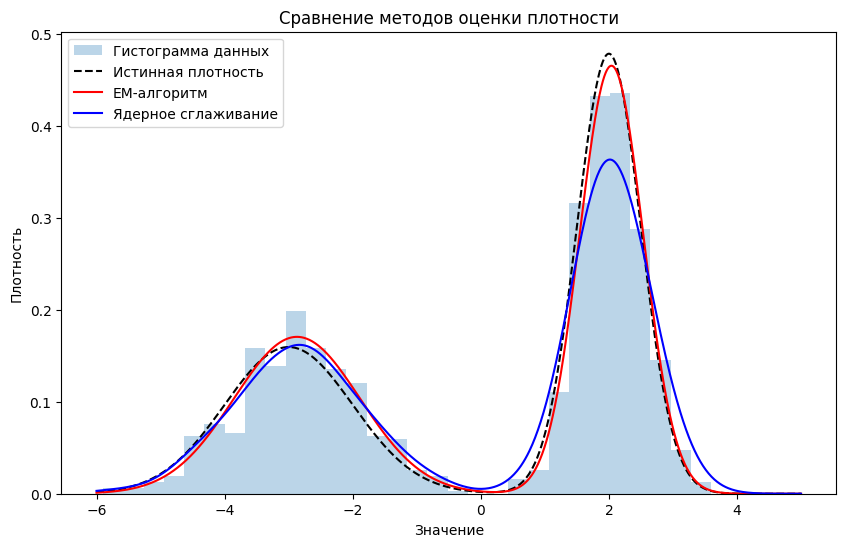

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Tuple, List, Optional

def generate_data(
    n_samples: int = 1000,
    mu: List[float] = [-3, 2],
    sigma: List[float] = [1, 0.5],
    weights: List[float] = [0.4, 0.6]
) -> np.ndarray:
    """
    Генерация случайных точек из смеси гауссовских распределений.

    Параметры:
        n_samples (int): Количество точек.
        mu (List[float]): Средние значения компонент.
        sigma (List[float]): Стандартные отклонения компонент.
        weights (List[float]): Веса компонент (должны суммироваться в 1).

    Возвращает:
        np.ndarray: Массив сгенерированных точек.
    """
    components = np.random.choice(len(weights), size=n_samples, p=weights)
    samples = np.zeros(n_samples)
    for i, (m, s) in enumerate(zip(mu, sigma)):
        mask = (components == i)
        samples[mask] = np.random.normal(m, s, size=mask.sum())
    return samples

class GaussianMixtureModel:
    """
    Реализация EM-алгоритма для оценки смеси гауссовских распределений.

    Атрибуты:
        n_components (int): Количество компонент.
        mu (np.ndarray): Средние значения компонент.
        sigma (np.ndarray): Стандартные отклонения компонент.
        weights (np.ndarray): Веса компонент.
        max_iter (int): Максимальное количество итераций.
        tol (float): Порог сходимости.
    """
    def __init__(
        self,
        n_components: int = 2,
        max_iter: int = 100,
        tol: float = 1e-6
    ) -> None:
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.mu = None
        self.sigma = None
        self.weights = None

    def fit(self, X: np.ndarray) -> None:
        """
        Обучение модели на данных с использованием EM-алгоритма.

        Параметры:
            X (np.ndarray): Входные данные формы (n_samples,).
        """
        n_samples = X.shape[0]

        # Инициализация параметров
        self.weights = np.ones(self.n_components) / self.n_components
        self.mu = np.linspace(np.min(X), np.max(X), self.n_components)
        self.sigma = np.array([np.std(X)] * self.n_components)

        prev_log_likelihood = -np.inf

        for _ in range(self.max_iter):
            # E-шаг: вычисление ответственностей
            responsibilities = self._compute_responsibilities(X)

            # M-шаг: обновление параметров
            self.weights = responsibilities.mean(axis=0)
            self.mu = (responsibilities.T @ X) / responsibilities.sum(axis=0)
            diff = (X[:, None] - self.mu)
            self.sigma = np.sqrt((responsibilities * diff**2).sum(axis=0) / responsibilities.sum(axis=0))

            # Проверка сходимости
            log_likelihood = self._compute_log_likelihood(X)
            if np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            prev_log_likelihood = log_likelihood

    def _compute_responsibilities(self, X: np.ndarray) -> np.ndarray:
        """Вычисление матрицы ответственностей."""
        likelihood = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            likelihood[:, i] = norm.pdf(X, loc=self.mu[i], scale=self.sigma[i])
        weighted_likelihood = likelihood * self.weights
        responsibilities = weighted_likelihood / weighted_likelihood.sum(axis=1, keepdims=True)
        return responsibilities

    def _compute_log_likelihood(self, X: np.ndarray) -> float:
        """Вычисление логарифма правдоподобия."""
        likelihood = np.zeros((X.shape[0], self.n_components))
        for i in range(self.n_components):
            likelihood[:, i] = norm.pdf(X, loc=self.mu[i], scale=self.sigma[i])
        weighted_likelihood = likelihood @ self.weights
        return np.log(weighted_likelihood).sum()

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Вычисление плотности распределения в точках X.

        Параметры:
            X (np.ndarray): Точки для оценки плотности.

        Возвращает:
            np.ndarray: Значения плотности.
        """
        density = np.zeros_like(X)
        for i in range(self.n_components):
            density += self.weights[i] * norm.pdf(X, loc=self.mu[i], scale=self.sigma[i])
        return density

def kernel_density_estimate(
    X: np.ndarray,
    points: np.ndarray,
    bandwidth: float = 0.5,
    kernel: str = 'gaussian'
) -> np.ndarray:
    """
    Оценка плотности методом ядерного сглаживания.

    Параметры:
        X (np.ndarray): Исходные данные.
        points (np.ndarray): Точки для оценки плотности.
        bandwidth (float): Ширина окна.
        kernel (str): Тип ядра ('gaussian' или 'epanechnikov').

    Возвращает:
        np.ndarray: Значения плотности в точках.
    """
    n = X.shape[0]
    density = np.zeros_like(points)
    for x in X:
        if kernel == 'gaussian':
            k = norm.pdf((points - x) / bandwidth)
        elif kernel == 'epanechnikov':
            u = (points - x) / bandwidth
            k = 0.75 * (1 - u**2) * (np.abs(u) <= 1)
        else:
            raise ValueError("Неподдерживаемый тип ядра")
        density += k
    density /= (n * bandwidth)
    return density

# Генерация данных
np.random.seed(42)
data = generate_data()

# Обучение модели EM-алгоритмом
gmm = GaussianMixtureModel(n_components=2)
gmm.fit(data)

# Ядерное сглаживание
points = np.linspace(-6, 5, 1000)
kde_density = kernel_density_estimate(data, points, bandwidth=0.4)

# Плотность EM-алгоритма
em_density = gmm.predict_proba(points)

# Истинная плотность (если известна)
true_density = 0.4 * norm.pdf(points, -3, 1) + 0.6 * norm.pdf(points, 2, 0.5)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, density=True, alpha=0.3, label='Гистограмма данных')
plt.plot(points, true_density, 'k--', label='Истинная плотность')
plt.plot(points, em_density, 'r-', label='EM-алгоритм')
plt.plot(points, kde_density, 'b-', label='Ядерное сглаживание')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('Сравнение методов оценки плотности')
plt.legend()
plt.show()